In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

[nltk_data] Downloading package stopwords to C:\Users\Bilal
[nltk_data]     Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Bilal
[nltk_data]     Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_parquet("train-00000-of-00001.parquet")
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [3]:
df.tail()

,text,label
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1
416808,i give you plenty of attention even when i fee...,0


In [4]:
df.shape #(rows, columns)

(416809, 2)

In [5]:
df.info() #Shows number of rows, columns, column names, data types, aur missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [6]:
df.describe() #Shows count, mean, std (standard deviation), min, max, aur percentiles (25%, 50%, 75%) of numeric columns.

,label
count,416809.000000
mean,1.554271
std,1.490453
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [7]:
print(df['label'].value_counts())

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


<Axes: xlabel='label'>

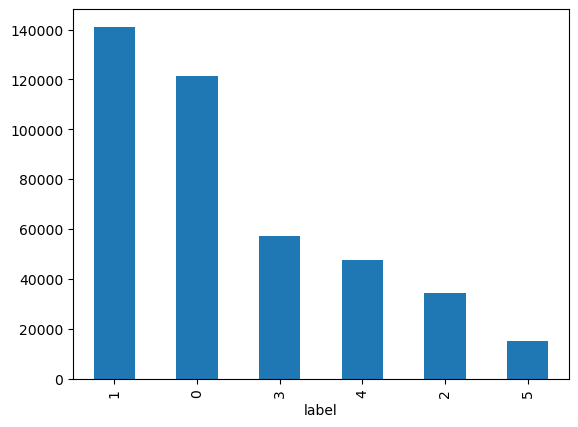

In [18]:
df['label'].value_counts().plot(kind='bar')

In [8]:
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
df['emotion'] = df['label'].map(emotion_map)

# Preview the updated dataframe
df[['text', 'emotion']].head()

,text,emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [19]:
df['emotion'].value_counts()

emotion
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64

In [9]:
df.dropna(inplace=True)
df = df.sample(frac=1).reset_index(drop=True)  # shuffle

In [10]:
#complete prepocessing done
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)

In [11]:
#sk tool to convert categorical to numeric
le = LabelEncoder()
df["emotion_label"] = le.fit_transform(df["emotion"])

print(le.classes_)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], #input feature in clean form
    df["emotion_label"],
    test_size=0.2,   #20%
    random_state=42     #spliation number ..same train and test data
    stratify=df["emotion_label"]  #emotion ratio same
)

In [13]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train) #first fit then convert into bag of words
X_test_tfidf  = tfidf.transform(X_test)

In [14]:
#logistic
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9017058132002591
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11463
           1       0.85      0.85      0.85      9542
           2       0.92      0.93      0.93     28214
           3       0.81      0.78      0.79      6911
           4       0.94      0.94      0.94     24238
           5       0.77      0.72      0.75      2994

    accuracy                           0.90     83362
   macro avg       0.87      0.85      0.86     83362
weighted avg       0.90      0.90      0.90     83362



In [15]:
#word fre + prb
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8493318298505315
              precision    recall  f1-score   support

           0       0.94      0.78      0.86     11463
           1       0.88      0.73      0.80      9542
           2       0.80      0.97      0.87     28214
           3       0.95      0.49      0.65      6911
           4       0.86      0.95      0.90     24238
           5       0.96      0.31      0.47      2994

    accuracy                           0.85     83362
   macro avg       0.90      0.71      0.76     83362
weighted avg       0.86      0.85      0.84     83362



In [16]:
#separates classes with max margin
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.8982869892756892
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11463
           1       0.84      0.85      0.85      9542
           2       0.92      0.93      0.92     28214
           3       0.79      0.78      0.79      6911
           4       0.94      0.94      0.94     24238
           5       0.73      0.71      0.72      2994

    accuracy                           0.90     83362
   macro avg       0.85      0.85      0.85     83362
weighted avg       0.90      0.90      0.90     83362



In [17]:
def predict_emotion(text):
    text = clean_text(text)
    vector = tfidf.transform([text])
    pred = svm.predict(vector)
    return le.inverse_transform(pred)[0]

predict_emotion("I feel very sad and lonely today")

'sadness'